# Loading Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras import regularizers

# gensim
import gensim
from gensim.models.keyedvectors import KeyedVectors

from wordcloud import WordCloud
from collections import Counter

import re
import string

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# defining function to clean text and retrive closs-validation datasets
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split



#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('all')

stopwords = set(stopwords.words('english'))

targets = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

word_counter={}


def cleantxt(c):
    punct = "?!/-.,#$%\()*+-/:;<=>@[\\]^_`{|}`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°\
£€\×™√²—–&'
    words = c.split()
    filtered_words = []
    wn = WordNetLemmatizer()
    for word in words:
        # replace punctuation with empty string
        for p in punct:
            if p in word:
                word = word.replace(p, '') 
        # if words not in stopwords add
        if word.lower() not in stopwords:
            filtered_words.append(wn.lemmatize(word.lower()))
        # ignore words with empty string
        if len(word)==0 or word==' ':
            filtered_words.remove(word)
    return ' '.join(filtered_words)


def clean_txt(text):
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in (stopwords)])

def clean_text(text):
    text = text.lower()
    text = re.sub(r"e.g", "", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", "", text)
    text = re.sub("ing", "", text)
    text = re.sub(r"s$", "", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r" just ", " ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r" did ", " ", text)
    text = re.sub(r" be ", " ", text)
    text = re.sub(r" am ", " ", text)
    text = re.sub(r" are ", " ", text)
    text = re.sub(r" is ", " ", text)
    text = re.sub(r" a ", " ", text)
    text = re.sub(r" was ", " ", text)
    text = re.sub(r" were ", " ", text)
    text = re.sub(r" an ", " ", text)
    text = re.sub(r" to ", " ", text)
    text = re.sub(r" of ", " ", text)
    text = re.sub(r" at ", " ", text)
    text = re.sub(r" for ", " ", text)
    text = re.sub(r" in ", " ", text)
    text = re.sub(r" on ", " ", text)
    text = re.sub(r" by ", " ", text)
    text = re.sub(r" into ", " ", text)
    text = re.sub(r" although ", " ", text)
    text = re.sub(r" above ", " ", text)
    text = re.sub(r" below ", " ", text)
    text = re.sub(r" from ", " ", text)
    text = re.sub(r" and ", " ", text)
    text = re.sub(r" or ", " ", text)
    text = re.sub(r" so ", " ", text)
    text = re.sub(r" as ", " ", text)
    text = re.sub(r" i ", " ", text)
    text = re.sub(r" she ", " ", text)
    text = re.sub(r" he ", " ", text)
    text = re.sub(r" his ", " ", text)
    text = re.sub(r" her ", " ", text)
    text = re.sub(r" hers ", " ", text)
    text = re.sub(r" him ", " ", text)
    text = re.sub(r" it ", " ", text)
    text = re.sub(r" they ", " ", text)
    text = re.sub(r" the ", " ", text)
    text = re.sub(r" this ", " ", text)
    text = re.sub(r" that ", " ", text)
    text = re.sub(r" we ", " ", text)
    text = re.sub(r" me ", " ", text)
    text = re.sub(r" us ", " ", text)
    text = re.sub(r" you ", " ", text)
    text = re.sub(r" who ", " ", text)
    text = re.sub(r" where ", " ", text)
    text = re.sub(r" whom ", " ", text)
    text = re.sub(r" whos ", " ", text)
    text = re.sub(r" what ", " ", text)
    
    text = text.strip(' ')
    return text


def process_data():
    
    df = pd.read_csv("train.csv")
    
    # Clean the text
    #df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))
    #df['comment_text'] = df['comment_text'].apply(lambda x : cleantxt(x))
    #df['comment_text'] = df['comment_text'].fillna(' ')
    
    # separate explanatory and dependent variables
    
    df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))
    df['comment_text'] = df['comment_text'].map(lambda com : cleantxt(com))


    for col in targets:    
        text = Counter()        

        # applying the clean-function to each column's comments and ...
        df[df[col] == 1]['comment_text'].apply(lambda t: text.update(clean_txt(t).split()))

        # combining all to one dataframe
        word_counter[col] = pd.DataFrame.from_dict(text, orient='index')\
                                            .rename(columns={0: 'count'})\
                                            .sort_values('count', ascending=False)

                                             
    df['comment_text'] = df['comment_text'].fillna(' ')
                                             
    X = df['comment_text']
    y = df[targets]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=247)
    
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = process_data()

In [4]:
X_train[925]

'wikipedia full fool take money make people work free wikipedia might well ban fool tak long wiki stupid place jimbo cult'

In [5]:
df = pd.read_csv("train.csv")
df['comment_text'][925]

"Wikipedia is full of fools. Who takes money and makes people work for free?  Wikipedia!!! You might as well ban me, you fool. What's taking so long? Wiki is a stupid place, it's Jimbo's Cult."

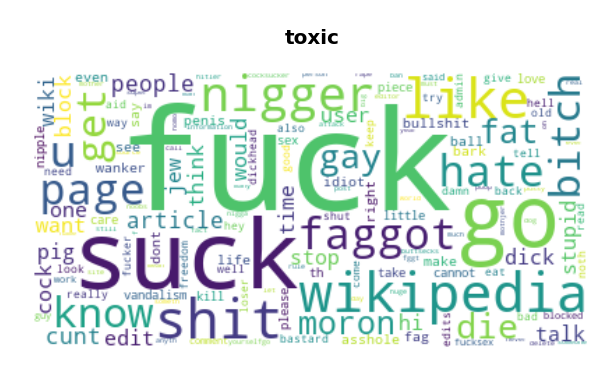

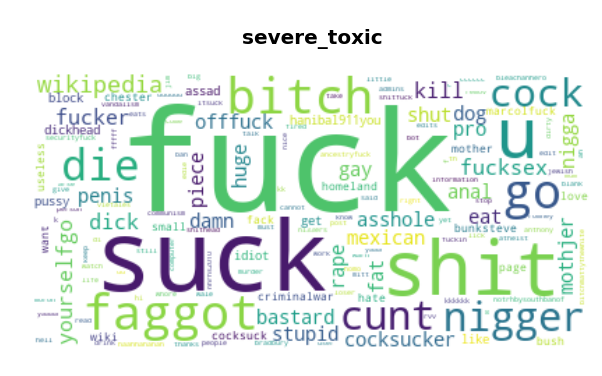

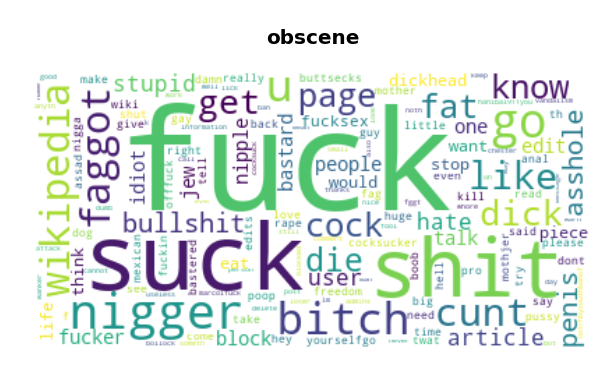

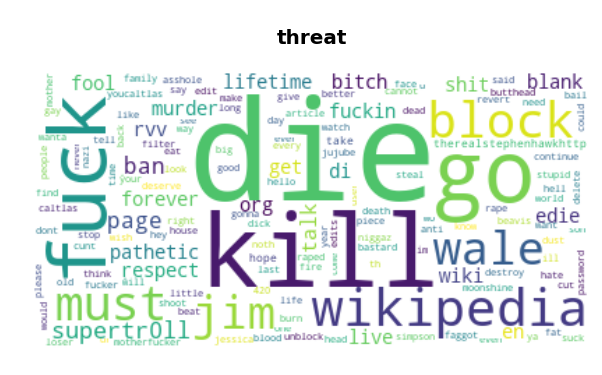

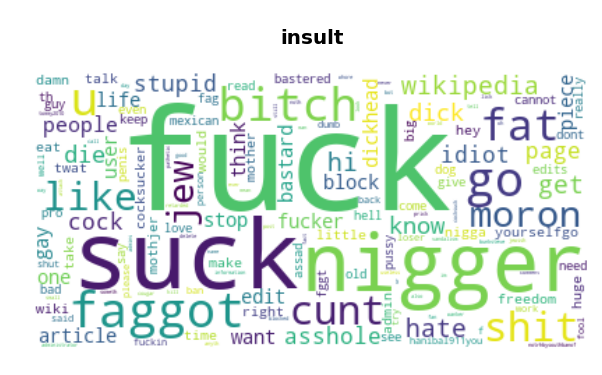

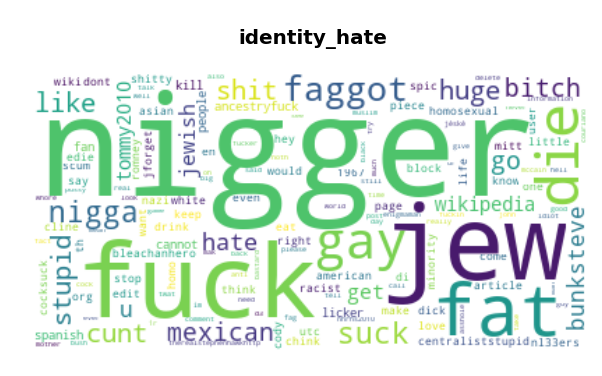

In [6]:
for col in word_counter:    
    wc_list = word_counter[col]
    
    wordcloud = WordCloud(background_color='white', max_words=150, max_font_size=100, random_state=4)\
                          .generate_from_frequencies(wc_list.to_dict()['count'])

    fig = plt.figure(figsize=(10, 8))
    plt.title('\n' + col + '\n', fontsize=20, fontweight='bold')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

In [7]:
# Tokenization

NUM_WORDS = 20000

tokenizer = Tokenizer(num_words=NUM_WORDS)

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

# Index Representation
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [8]:
# Most sentence length is 30, choose maxlen=50-100

maxlen=100

X_train = pad_sequences(sequences_train,maxlen=maxlen)
X_test = pad_sequences(sequences_test,maxlen=maxlen)

# Convert target to array
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)



# Printing shape
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

Shape of X_train: (127656, 100)
Shape of y_train: (127656, 6)


# Tried upsampling, but performance was bad

loss, accuracy, f1_score, precision, recall=
1.2149358352635435 0.20189044640231577 0.08093274772778847 0.04283252413239148 0.9616555367669547

In [9]:
#X_train = pd.DataFrame(X_train)
#print('Shape of X_train:', type(X_train))

In [10]:
#X_train.head()

In [11]:
"""
from sklearn.neighbors import NearestNeighbors
import random

def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    '''
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    '''
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    '''
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    '''
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    '''
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    '''
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    '''
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    '''
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target
"""

"\nfrom sklearn.neighbors import NearestNeighbors\nimport random\n\ndef get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:\n    '''\n    Find the underrepresented targets.\n    Underrepresented targets are those which are observed less than the median occurance.\n    Targets beyond a quantile limit are filtered.\n    '''\n    irlbl = df.sum(axis=0)\n    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering\n    irlbl = irlbl.max() / irlbl\n    threshold_irlbl = irlbl.median()\n    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()\n    return tail_label\n\ndef get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):\n    '''\n    return\n    X_sub: pandas.DataFrame, the feature vector minority dataframe\n    y_sub: pandas.DataFrame, the target vector minority dataframe\n    '''\n    tail_labels = get_tail_label(y, ql=ql)\n    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()\n    \n    

In [12]:
#X_sub, y_sub = get_minority_samples(X_train, y_train)

In [13]:
#X_res, y_res = MLSMOTE(X_sub, y_sub, 100, 5)

In [14]:
#X_res.tail()

In [15]:
"""
label_count = y_res[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()
label_count.plot(kind='bar', title='Labels Count')
"""

"\nlabel_count = y_res[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()\nlabel_count.plot(kind='bar', title='Labels Count')\n"

In [16]:
'''
print(type(X_res))
print(type(y_res))
X_train = np.asarray(X_res)
y_train = np.asarray(y_res)
'''

'\nprint(type(X_res))\nprint(type(y_res))\nX_train = np.asarray(X_res)\ny_train = np.asarray(y_res)\n'

In [17]:
# Use pretrain Word2Vec model from Google https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# Contains 300-dimensional vectors for 3 million words and phrases 

word2vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [18]:
# Build embedding matrix and embedding layer
EMBEDDING_DIM=300
vocabulary_size=len(word_index)+1

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))


for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_matrix[i] = word2vectors[word]
    except KeyError:
        embedding_matrix[i] = np.zeros(EMBEDDING_DIM)                  

In [19]:
filter_sizes = 3
num_filters = 100

inputs = Input(shape=(maxlen,))
embedding = Embedding(vocabulary_size,EMBEDDING_DIM,weights=[embedding_matrix],trainable=True)(inputs)
reshape = Reshape((maxlen,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes, EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
maxpool_0 = MaxPooling2D((maxlen - filter_sizes + 1, 1), strides=(1,1))(conv_0)

conv_1 = Conv2D(num_filters, (filter_sizes, EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
maxpool_1 = MaxPooling2D((maxlen - filter_sizes + 1, 1), strides=(1,1))(conv_1)

merged = concatenate([maxpool_0, maxpool_1], axis=1)
flatten = Flatten()(merged)
reshape = Reshape((2*num_filters,))(flatten)
dropout = Dropout(0.5)(flatten)
conc = Dense(40)(dropout)
output = Dense(units=6, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(conc)

model = Model(inputs, output)

In [20]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',f1_m, precision_m, recall_m])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     47266800    input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 300, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 98, 1, 100)   90100       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

In [21]:
#callbacks = [EarlyStopping(monitor='val_f1_m', patience=3, restore_best_weights=True)]
callbacks = [EarlyStopping(monitor='val_f1_m', patience=3)]
model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=2, validation_split=0.1, callbacks=callbacks)

Train on 114890 samples, validate on 12766 samples
Epoch 1/10
 - 20s - loss: 0.1556 - acc: 0.9734 - f1_m: 0.4847 - precision_m: 0.7646 - recall_m: 0.3835 - val_loss: 0.0814 - val_acc: 0.9803 - val_f1_m: 0.6570 - val_precision_m: 0.8455 - val_recall_m: 0.5431
Epoch 2/10
 - 14s - loss: 0.0812 - acc: 0.9788 - f1_m: 0.6503 - precision_m: 0.8142 - recall_m: 0.5515 - val_loss: 0.0711 - val_acc: 0.9799 - val_f1_m: 0.6415 - val_precision_m: 0.8634 - val_recall_m: 0.5158
Epoch 3/10
 - 15s - loss: 0.0733 - acc: 0.9795 - f1_m: 0.6701 - precision_m: 0.8146 - recall_m: 0.5765 - val_loss: 0.0663 - val_acc: 0.9812 - val_f1_m: 0.6993 - val_precision_m: 0.8043 - val_recall_m: 0.6240
Epoch 4/10
 - 14s - loss: 0.0699 - acc: 0.9799 - f1_m: 0.6782 - precision_m: 0.8138 - recall_m: 0.5895 - val_loss: 0.0653 - val_acc: 0.9814 - val_f1_m: 0.7088 - val_precision_m: 0.7934 - val_recall_m: 0.6452
Epoch 5/10
 - 15s - loss: 0.0673 - acc: 0.9805 - f1_m: 0.6902 - precision_m: 0.8182 - recall_m: 0.6054 - val_loss: 0.

In [22]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [23]:
(loss, accuracy, f1_score, precision, recall) = model.evaluate(X_test, y_test, verbose=1)

31915/31915 [==============================] - 3s 89us/step


In [24]:
print(loss, accuracy, f1_score, precision, recall)

0.06758988705825118 0.9804741626003964 0.6187390702879767 0.7129054933100047 0.585126293861584


In [25]:
from sklearn import metrics
from sklearn.metrics import classification_report

AUC = np.zeros((2,6))

for i,x in enumerate(targets):
    auc = np.array([metrics.roc_auc_score(y_train[:,i], y_pred_train[:,i]),
                    metrics.roc_auc_score(y_test[:,i], y_pred_test[:,i])])
    print(x)
    print("Train AUC:",auc[0],"Test AUC:",auc[1])
    AUC[:,i] = auc
    
    y_pred = np.where(y_pred_test[:,i]>0.5,1,0)
    
    print(classification_report(y_test[:,i], y_pred))

    avg_auc = AUC.mean(axis=1)
print("Average Train AUC:",avg_auc[0],"Average Test AUC:",avg_auc[1])

toxic
Train AUC: 0.982183141032962 Test AUC: 0.9679734484757517
             precision    recall  f1-score   support

          0       0.97      0.99      0.98     28844
          1       0.83      0.68      0.75      3071

avg / total       0.95      0.96      0.95     31915

severe_toxic
Train AUC: 0.9890319346245657 Test AUC: 0.9822101398787324
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     31614
          1       0.46      0.27      0.34       301

avg / total       0.99      0.99      0.99     31915

obscene
Train AUC: 0.9923091785732565 Test AUC: 0.986635096788354
             precision    recall  f1-score   support

          0       0.99      0.99      0.99     30274
          1       0.79      0.78      0.78      1641

avg / total       0.98      0.98      0.98     31915

threat
Train AUC: 0.9505148887857071 Test AUC: 0.9270936545343458
             precision    recall  f1-score   support

          0       1.00      1.00 